# Deep Learning: Sentiment Analysis

- Let's get back to the Senitment Analysis on the NLTK Movie Reviews datasets 

![](../images/keras-workflow.png)

## Prepare Data

In [327]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [328]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text,1) if label=="pos" else (text, 0) for (text, label) in documents]

random.shuffle(documents)

# labeled_names = ([(name, 1) for name in names.words('male.txt')] +
#                  [(name, 0) for name in names.words('female.txt')])
# random.shuffle(labeled_names)

In [329]:
documents[1]

('recently one night a young director named baz luhrmann couldn \' t sleep . he tumbled out of bed and moved over to the television where he watched mtv for an hour . then he moved to his kitchen where he spent the same amount of time eating spoiled food . then he took down a volume of shakespeare \' s work and read it cover to cover - never really paying attention to the words or plot . and then , as a climax , he took out his video camera and pressed the " on " button . the result ? william shakespeare \' s romeo + juliet - the worst film ever made and a complete failure . though , to be fair , an interesting complete failure . the idea at the film \' s core is to make shakespeare appealing to the crowds . this is done by moving the camera around at a rapid rate so that we can \' t see what is going on . and filming the dialogue in voice over . and shooting leonardo dicaprio like a calvin klein model . and making the frame go still while flashing the character \' s name at the bottom

## Train-Test Split

In [330]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents, test_size = 0.1, random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- In deep learning, words or characters are automatically converted into numeric representations.
- In other words, the feature engineering step is fully automatic.

- Steps:
    - Text to Integers
    - Padding each instance to be of same lengths
    

In [427]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Bidirectional

In [378]:
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set] 

In [333]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- By default, the token index 0 is reserved for padding token.
- If `oov_token` is specified, it is default to index 1.
- Specify `num_words` for tokenizer to include only top N words in the model
- Tokenizer will automatically remove puntuations.
- Tokenizer use whitespace as word delimiter.
- If every character is treated as a token, specify `char_level=True`.

In [334]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- if `oov_token` is specified, then the vocabulary size needs to be added one more.

In [335]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 10001


In [ ]:
list(tokenizer.word_index.items())[:20]

In [337]:
len(tokenizer.word_index)

37773

## Text Vectorization

### From Texts and Tensors

- Like in feature-based machine translation, a computational model only accepts numeric values. It is necessary to convert raw text to numeric tensor for neural network.
- There are two main ways of text vectorization:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of tokens in texts and learn token **embeddings**

## Define X and Y

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [397]:
texts_ints = tokenizer.texts_to_sequences(texts)

#### Padding

- To make sure each input text consists of the same number of tokens.

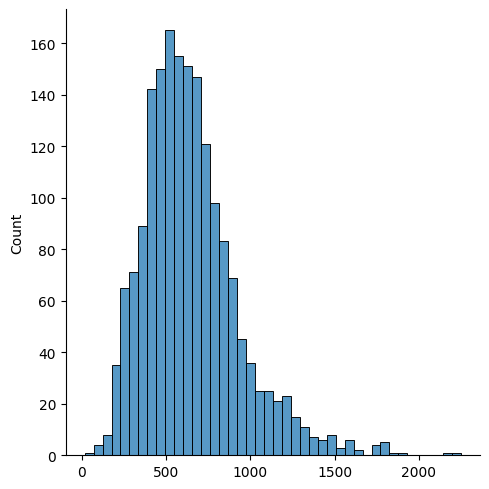

In [398]:
texts_lens=[len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)
#print(texts[np.argmax(texts_lens)]) # longest name

In [399]:
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2250

- We consider the final 400 tokens of each text.
- `padding` and `truncating` parameters in `pad_sequences`: whether to Pre-padding or removing values from the beginning of the sequence (i.e., `pre`) or the other way (`post`).

In [400]:
max_len = 400

In [401]:
texts_ints_pad = sequence.pad_sequences(texts_ints, maxlen = max_len, truncating='pre', padding='pre')
texts_ints_pad[:10]

array([[2418,   13,   29, ..., 4406,   84,   39],
       [ 531, 2516, 1317, ...,   63, 6286, 2977],
       [ 329,  628,  124, ...,    9,  354,    8],
       ...,
       [  74,  202,   45, ...,    4,    1,  101],
       [ 809,  469,    7, ...,    4,   38,   65],
       [6953,    3, 1239, ...,  598,   15,   26]], dtype=int32)

In [402]:
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(
        [n for (n, l) in test_set]),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

X_test_texts = [n for (n, l) in test_set]

In [403]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding)

- text to matrix (one-hot encode)
- choose modes for bag-of-words (binary, count, tfidf)

In [345]:
texts_matrix = tokenizer.texts_to_matrix(texts, mode="count")

In [346]:
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

X_test2 = tokenizer.texts_to_matrix([n for (n,l) in test_set], mode="count").astype('int32')
y_test2 = np.array([l for (n,l) in test_set])

X_test2_texts = [n for (n,l) in test_set]

In [347]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Model Definition

In [348]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

In [349]:
from keras import layers
model1 = keras.Sequential()
model1.add(keras.Input(shape=(NUM_WORDS,)))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model1.add(layers.Dense(2, activation="softmax", name="output"))

model1.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)


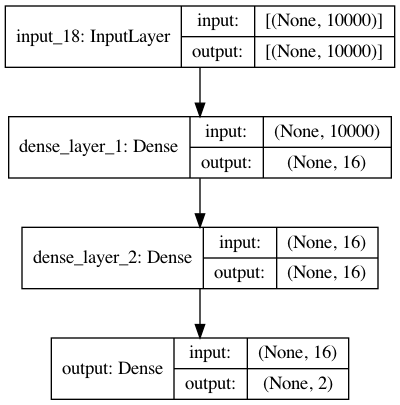

In [350]:
plot_model(model1, show_shapes=True )

In [351]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2

In [352]:
history1 = model1.fit(X_train2, y_train2, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6425 - accuracy: 0.6187 - val_loss: 0.5438 - val_accuracy: 0.7611
Epoch 2/25
12/12 - 0s - loss: 0.3729 - accuracy: 0.8847 - val_loss: 0.4273 - val_accuracy: 0.8194
Epoch 3/25
12/12 - 0s - loss: 0.2125 - accuracy: 0.9549 - val_loss: 0.4092 - val_accuracy: 0.8306
Epoch 4/25
12/12 - 0s - loss: 0.1220 - accuracy: 0.9833 - val_loss: 0.3854 - val_accuracy: 0.8361
Epoch 5/25
12/12 - 0s - loss: 0.0681 - accuracy: 0.9965 - val_loss: 0.3480 - val_accuracy: 0.8444
Epoch 6/25
12/12 - 0s - loss: 0.0387 - accuracy: 1.0000 - val_loss: 0.3434 - val_accuracy: 0.8611
Epoch 7/25
12/12 - 0s - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.3520 - val_accuracy: 0.8639
Epoch 8/25
12/12 - 0s - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.3639 - val_accuracy: 0.8639
Epoch 9/25
12/12 - 0s - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.3909 - val_accuracy: 0.8556
Epoch 10/25
12/12 - 0s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.3999 - val_accuracy: 0.8556
Epoch 11/25
12/12 -

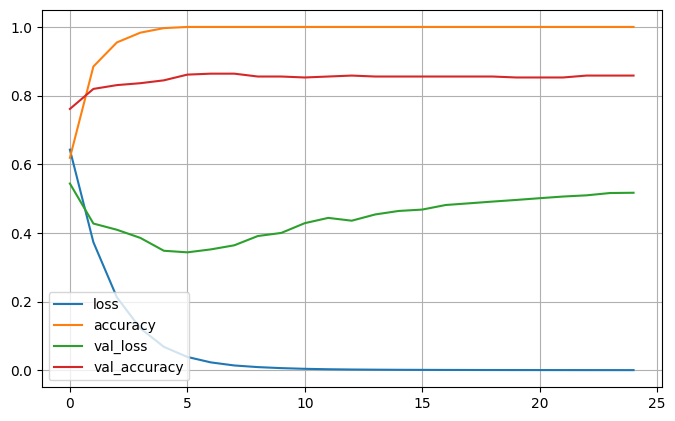

In [353]:
plot2(history1)

In [354]:
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.4469 - accuracy: 0.8750


[0.4468931257724762, 0.875]

### Model 2

- One Embedding Layer + Two layers of fully-connected dense layers
- The Input is the integer encodings of texts from the padded text-to-sequence.

In [355]:
EMBEDDING_DIM = 128
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model2.add(layers.GlobalAveragePooling1D()) ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model2.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model2.add(layers.Dense(2, activation="softmax", name="output"))

model2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

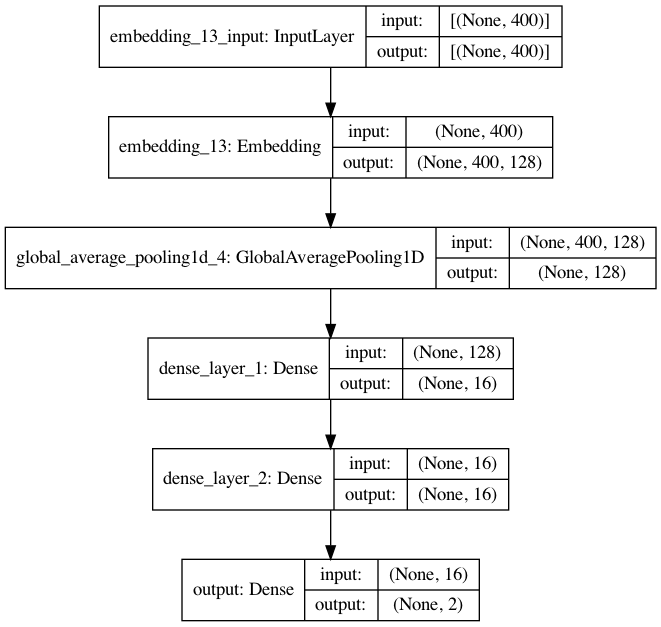

In [356]:
plot_model(model2, show_shapes=True)

In [357]:
history2 = model2.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6918 - accuracy: 0.6021 - val_loss: 0.6905 - val_accuracy: 0.5500
Epoch 2/25
12/12 - 0s - loss: 0.6832 - accuracy: 0.7681 - val_loss: 0.6841 - val_accuracy: 0.6278
Epoch 3/25
12/12 - 0s - loss: 0.6683 - accuracy: 0.8528 - val_loss: 0.6706 - val_accuracy: 0.7833
Epoch 4/25
12/12 - 0s - loss: 0.6432 - accuracy: 0.8965 - val_loss: 0.6487 - val_accuracy: 0.8111
Epoch 5/25
12/12 - 0s - loss: 0.6008 - accuracy: 0.9083 - val_loss: 0.6123 - val_accuracy: 0.8333
Epoch 6/25
12/12 - 0s - loss: 0.5376 - accuracy: 0.9243 - val_loss: 0.5619 - val_accuracy: 0.8194
Epoch 7/25
12/12 - 0s - loss: 0.4546 - accuracy: 0.9375 - val_loss: 0.5066 - val_accuracy: 0.8389
Epoch 8/25
12/12 - 0s - loss: 0.3572 - accuracy: 0.9604 - val_loss: 0.4468 - val_accuracy: 0.8444
Epoch 9/25
12/12 - 0s - loss: 0.2654 - accuracy: 0.9701 - val_loss: 0.4001 - val_accuracy: 0.8444
Epoch 10/25
12/12 - 0s - loss: 0.1854 - accuracy: 0.9819 - val_loss: 0.3640 - val_accuracy: 0.8528
Epoch 11/25
12/12 -

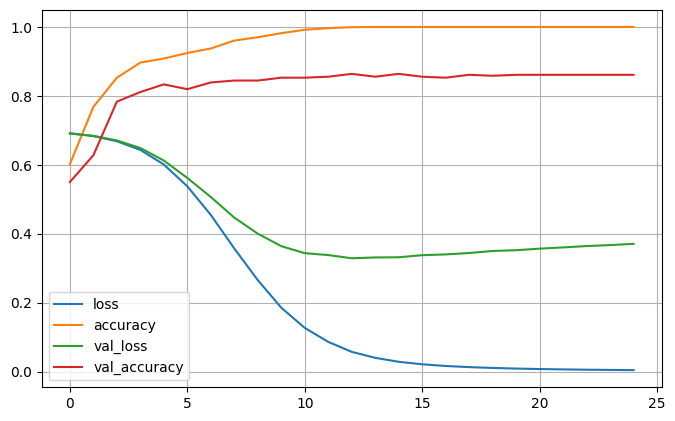

In [358]:
plot2(history2)

In [359]:
model2.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.3715 - accuracy: 0.8500


[0.37151727080345154, 0.8500000238418579]

## Check Embeddings

- Compared to one-hot encodings of characters, embeddings may include more information relating to the characteristics of the characters.
- We can extract the embedding layer and apply dimensional reduction techniques (i.e., TSNE) to see how embeddings capture the relationships in-between characters.

In [364]:
ind2word = tokenizer.index_word

In [371]:
# check first N words for text
' '.join([ind2word.get(i) for i in X_test[1][-50:] if ind2word.get(i)!= None])

"in the world who seemed to enjoy robert king ' s previous screenplay the dana flop clean so i had some hopes for but while there is wit in the words this is a script which was probably much better on paper on screen it ' s still paper thin"

In [374]:
X_test_texts[1][-287:]

"in the civilized world who seemed to enjoy robert king ' s previous screenplay , the dana carvey flop clean slate , so i had some hopes for speechless . but while there is wit in the words , this is a script which was probably much better on paper . on screen , it ' s still paper thin ."

In [375]:
word_vectors = model2.layers[0].get_weights()[0]
word_vectors.shape

(10001, 128)

In [380]:
token_labels = [word for (ind, word) in tokenizer.index_word.items()]
token_labels.insert(0,None)
token_labels[:10]

[None, 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

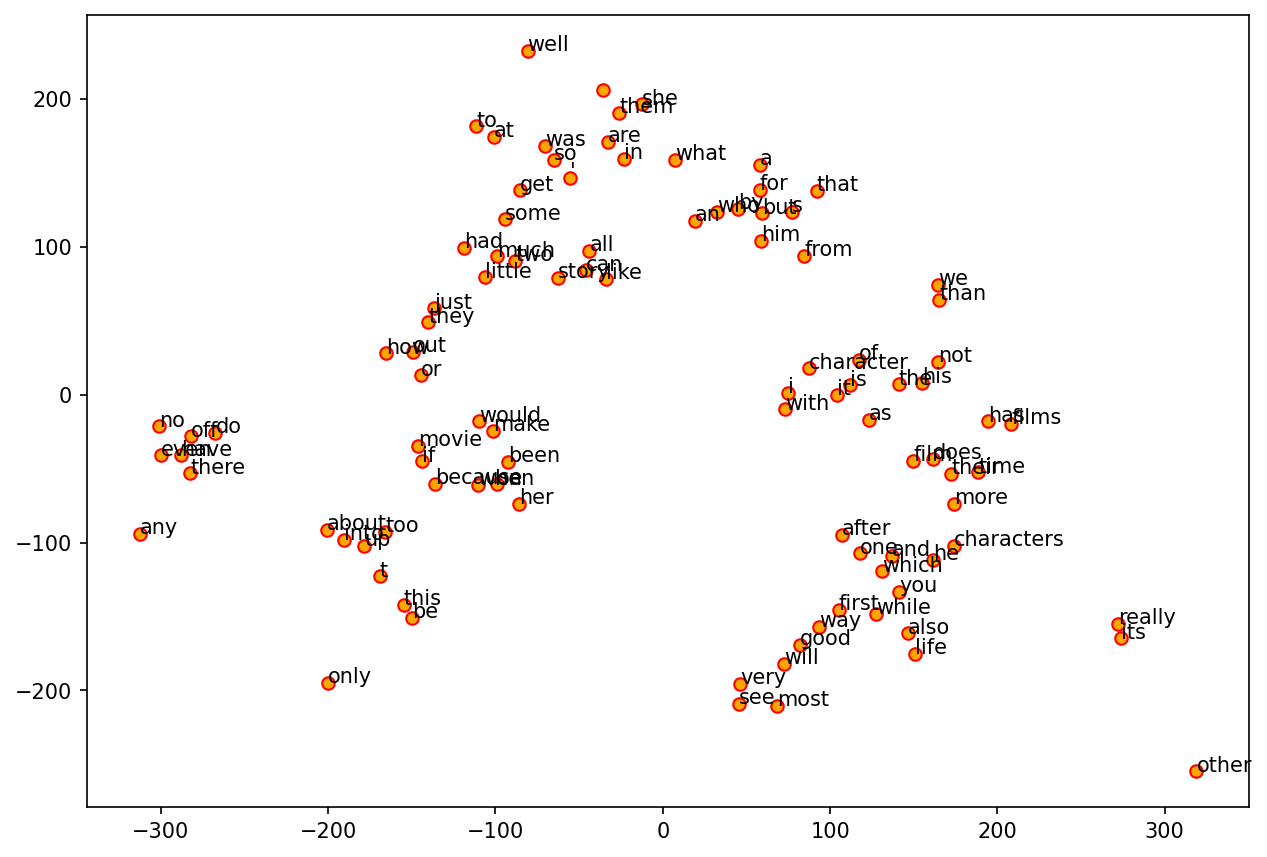

In [387]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[:100,])
labels = labels

plt.figure(figsize=(10, 7), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(token_labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+0.01, y+0.01), xytext=(0, 0), textcoords='offset points')

## Issues of Word/Character Representations

- One-hot encoding does not indicate semantic relationships between characters.
- For deep learning NLP, it is preferred to convert one-hot encodings of words/characters into embeddings, which are argued to include more semantic information of the tokens.
- Now the question is how to train and create better word embeddings. We will come back to this issue later.

- Generally speaking, we can train our word embeddings along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these later.

## Hyperparameter Tuning

:::{note}

Please install keras tuner module in your current conda:
```
pip install -U keras-tuner
```

:::

- Like feature-based ML methods, neural networks also come with many hyperparameters, which require default values.
- Typical hyperparameters include:
    - Number of nodes for the layer
    - Learning Rates
- We can utilize the module, [`keras-tuner`](https://keras-team.github.io/keras-tuner/documentation/tuners/), to fine-tune the hyperparameters.

- Steps for Keras Tuner
    - First, wrap the model definition in a function, which takes a single `hp` argument. 
    - Inside this function, replace any value we want to tune with a call to hyperparameter sampling methods, e.g. `hp.Int()` or `hp.Choice()`. The function should return a compiled model.
    - Next, instantiate a tuner object specifying your optimization objective and other search parameters.
    - Finally, start the search with the `search()` method, which takes the same arguments as `Model.fit()` in keras.
    - When search is over, we can retrieve the best model and a summary of the results from the `tunner`.


In [34]:
import kerastuner

In [35]:
## Wrap model definition in a function
## and specify the parameters needed for tuning
def build_model(hp):
    model1 = keras.Sequential()
    model1.add(keras.Input(shape=(max_len,)))
    model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_1"))
    model1.add(layers.Dense(hp.Int('units', min_value=32, max_value=128, step=32), activation="relu", name="dense_layer_2"))
    model1.add(layers.Dense(2, activation="softmax", name="output"))
    model1.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model1

# def build_model(hp):
#     inputs = keras.Input(shape=(784,))
#     x = layers.Dense(
#         units=hp.Int('units', min_value=32, max_value=512, step=32),
#         activation='relu'))(inputs)
#     outputs = layers.Dense(10, activation='softmax')(x)
#     model = keras.Model(inputs, outputs)
#     model.compile(
#         optimizer=keras.optimizers.Adam(
#             hp.Choice('learning_rate',
#                       values=[1e-2, 1e-3, 1e-4])),
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy'])
#     return model

In [36]:
## This is to clean up the temp dir from the tuner
## Every time we re-start the tunner, it's better to keep the temp dir clean

import os
import shutil

if os.path.isdir('my_dir'):
    shutil.rmtree('my_dir')
    

In [37]:
## Instantiate the tunner

tuner = kerastuner.tuners.RandomSearch(
  build_model,
  objective='val_accuracy',
  max_trials=10,
  executions_per_trial=3,
  directory='my_dir')

In [38]:
## Check the tuner's search space
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [39]:
## Start tuning with the tuner
tuner.search(X_train, y_train, validation_split=0.2, batch_size=128)

Trial 8 Complete [00h 00m 01s]
val_accuracy: 0.6126409769058228

Best val_accuracy So Far: 0.7123000423113505
Total elapsed time: 00h 00m 13s
INFO:tensorflow:Oracle triggered exit


In [40]:
## Retrieve the best models from the tuner
models = tuner.get_best_models(num_models=2)

In [41]:
## Retrieve the summary of results from the tuner
tuner.results_summary()

Results summary
Results in my_dir/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.7123000423113505
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.01
Score: 0.7081038554509481
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.7060057719548544
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.001
Score: 0.7052189707756042
Trial summary
Hyperparameters:
units: 96
learning_rate: 0.0001
Score: 0.6163126031557719
Trial summary
Hyperparameters:
units: 128
learning_rate: 0.0001
Score: 0.6131654779116312
Trial summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 0.6126409769058228
Trial summary
Hyperparameters:
units: 64
learning_rate: 0.0001
Score: 0.5612378716468811


## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the padded text-to-sequences

In [411]:
EMBEDDING_DIM = 128
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
#model3.add(SpatialDropout1D(0.2))
model3.add(LSTM(16, dropout=0.5, recurrent_dropout=0.5))
model3.add(Dense(2, activation="softmax"))

model3.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

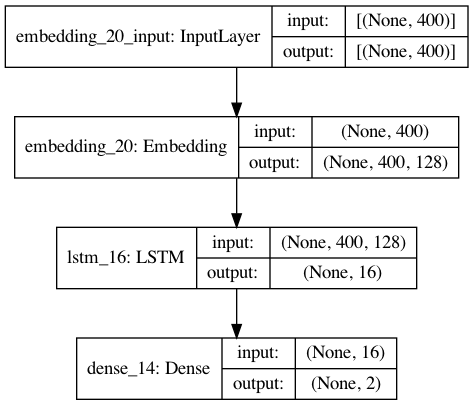

In [412]:
plot_model(model3, show_shapes=True)

In [413]:
history3 = model3.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 7s - loss: 0.6924 - accuracy: 0.5181 - val_loss: 0.6928 - val_accuracy: 0.4972
Epoch 2/25
12/12 - 4s - loss: 0.6770 - accuracy: 0.6764 - val_loss: 0.6886 - val_accuracy: 0.5444
Epoch 3/25
12/12 - 4s - loss: 0.6479 - accuracy: 0.7701 - val_loss: 0.6814 - val_accuracy: 0.5472
Epoch 4/25
12/12 - 4s - loss: 0.5727 - accuracy: 0.8076 - val_loss: 0.6345 - val_accuracy: 0.6389
Epoch 5/25
12/12 - 4s - loss: 0.4099 - accuracy: 0.8681 - val_loss: 0.7137 - val_accuracy: 0.7000
Epoch 6/25
12/12 - 4s - loss: 0.2681 - accuracy: 0.9292 - val_loss: 0.5185 - val_accuracy: 0.7667
Epoch 7/25
12/12 - 4s - loss: 0.1840 - accuracy: 0.9569 - val_loss: 0.5639 - val_accuracy: 0.7444
Epoch 8/25
12/12 - 4s - loss: 0.1209 - accuracy: 0.9764 - val_loss: 0.7161 - val_accuracy: 0.6944
Epoch 9/25
12/12 - 4s - loss: 0.0938 - accuracy: 0.9826 - val_loss: 0.5285 - val_accuracy: 0.7861
Epoch 10/25
12/12 - 4s - loss: 0.0701 - accuracy: 0.9903 - val_loss: 0.6400 - val_accuracy: 0.7694
Epoch 11/25
12/12 -

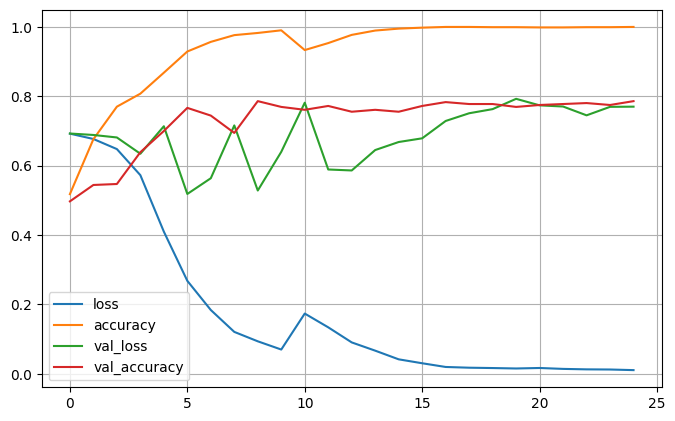

In [414]:
plot2(history3)

In [416]:
model3.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.8678 - accuracy: 0.7450


[0.8678088188171387, 0.7450000047683716]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer

In [418]:
EMBEDDING_DIM = 128
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.1, recurrent_dropout=0.5)) #)
model4.add(LSTM(16, dropout=0.1, recurrent_dropout=0.5))
model4.add(Dense(2, activation="softmax"))

model4.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

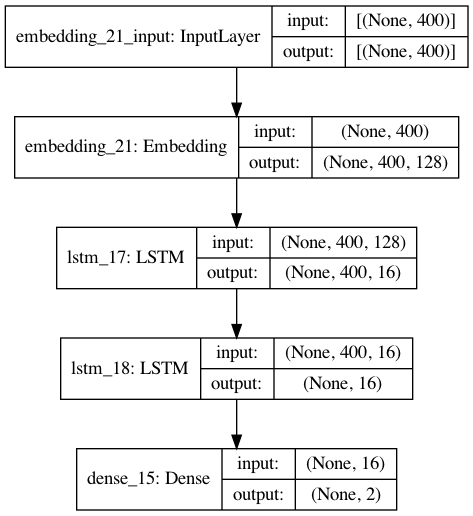

In [419]:
plot_model(model4,show_shapes=True)

In [420]:
history4 = model4.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6919 - accuracy: 0.5222 - val_loss: 0.6926 - val_accuracy: 0.4778
Epoch 2/25
12/12 - 7s - loss: 0.6735 - accuracy: 0.6035 - val_loss: 0.6910 - val_accuracy: 0.4889
Epoch 3/25
12/12 - 7s - loss: 0.6065 - accuracy: 0.7854 - val_loss: 0.6521 - val_accuracy: 0.6222
Epoch 4/25
12/12 - 7s - loss: 0.4475 - accuracy: 0.8639 - val_loss: 0.6406 - val_accuracy: 0.6944
Epoch 5/25
12/12 - 8s - loss: 0.2879 - accuracy: 0.9181 - val_loss: 0.6458 - val_accuracy: 0.7000
Epoch 6/25
12/12 - 8s - loss: 0.1557 - accuracy: 0.9764 - val_loss: 0.6451 - val_accuracy: 0.7333
Epoch 7/25
12/12 - 8s - loss: 0.0978 - accuracy: 0.9875 - val_loss: 0.6710 - val_accuracy: 0.7444
Epoch 8/25
12/12 - 9s - loss: 0.0615 - accuracy: 0.9944 - val_loss: 0.7449 - val_accuracy: 0.7306
Epoch 9/25
12/12 - 9s - loss: 0.0448 - accuracy: 0.9958 - val_loss: 0.8253 - val_accuracy: 0.7444
Epoch 10/25
12/12 - 8s - loss: 0.0312 - accuracy: 0.9972 - val_loss: 0.8733 - val_accuracy: 0.7528
Epoch 11/25
12/12 

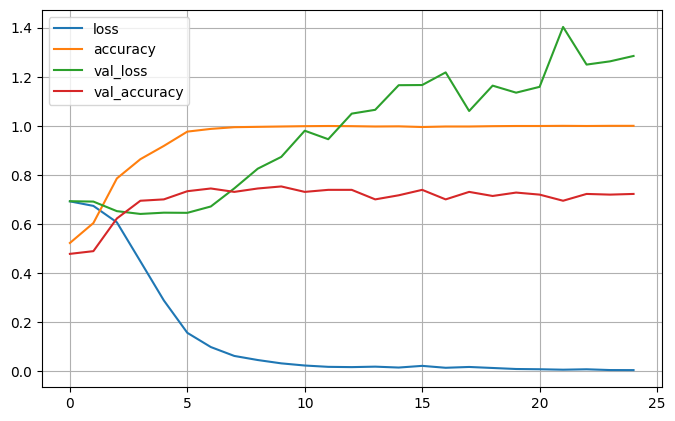

In [424]:
plot2(history4)

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer

In [428]:
EMBEDDING_DIM = 128
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
#model3.add(SpatialDropout1D(0.2))
model5.add(Bidirectional(LSTM(16, dropout=0.5, recurrent_dropout=0.5)))
model5.add(Dense(2, activation="softmax"))

model5.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

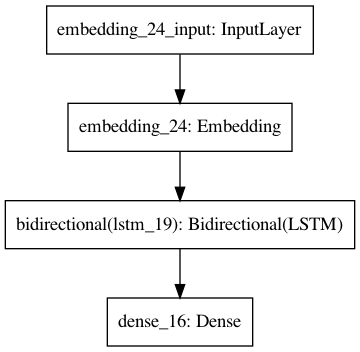

In [429]:
plot_model(model5)

In [430]:
history5 = model5.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6914 - accuracy: 0.5215 - val_loss: 0.6938 - val_accuracy: 0.4889
Epoch 2/25
12/12 - 7s - loss: 0.6739 - accuracy: 0.7118 - val_loss: 0.6936 - val_accuracy: 0.4972
Epoch 3/25
12/12 - 7s - loss: 0.6426 - accuracy: 0.7875 - val_loss: 0.6870 - val_accuracy: 0.5444
Epoch 4/25
12/12 - 7s - loss: 0.5540 - accuracy: 0.8618 - val_loss: 0.5917 - val_accuracy: 0.7056
Epoch 5/25
12/12 - 7s - loss: 0.3835 - accuracy: 0.8660 - val_loss: 0.6416 - val_accuracy: 0.7194
Epoch 6/25
12/12 - 7s - loss: 0.2484 - accuracy: 0.9389 - val_loss: 0.4783 - val_accuracy: 0.7583
Epoch 7/25
12/12 - 7s - loss: 0.1469 - accuracy: 0.9639 - val_loss: 0.4680 - val_accuracy: 0.7833
Epoch 8/25
12/12 - 7s - loss: 0.1053 - accuracy: 0.9806 - val_loss: 0.4771 - val_accuracy: 0.8028
Epoch 9/25
12/12 - 7s - loss: 0.0584 - accuracy: 0.9979 - val_loss: 0.5175 - val_accuracy: 0.7889
Epoch 10/25
12/12 - 7s - loss: 0.0449 - accuracy: 0.9979 - val_loss: 0.5132 - val_accuracy: 0.8083
Epoch 11/25
12/12 

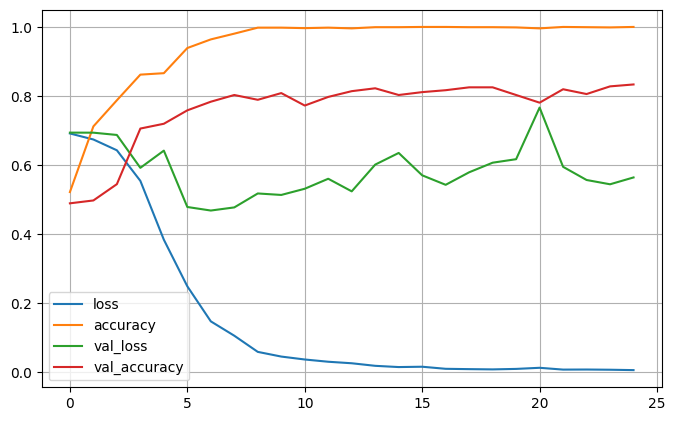

In [431]:
plot2(history5)

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer

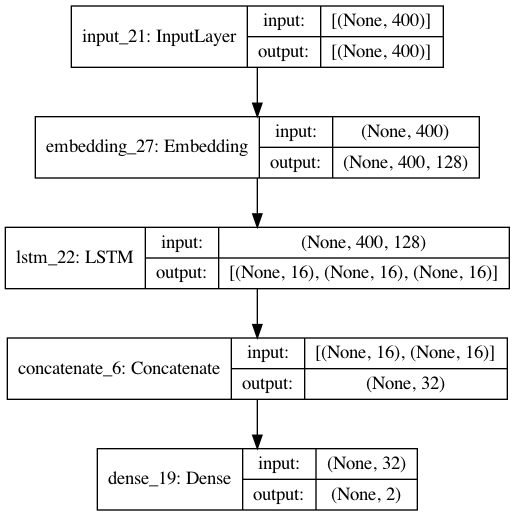

In [435]:
EMBEDDING_DIM = 128

inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True)(inputs)
#x=layers.SpatialDropout1D(0.2)(x)
x_all_h,x_last_h, x_c = layers.LSTM(16, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=False, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = layers.Concatenate(axis=1)([x_last_h, x_c])
outputs=layers.Dense(2, activation='softmax')(x)
model6 = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

plot_model(model6, show_shapes=True)

In [436]:
model6.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history6 = model6.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6900 - accuracy: 0.5375 - val_loss: 0.6879 - val_accuracy: 0.5306
Epoch 2/25
12/12 - 5s - loss: 0.6514 - accuracy: 0.7542 - val_loss: 0.6824 - val_accuracy: 0.5583
Epoch 3/25
12/12 - 5s - loss: 0.5776 - accuracy: 0.8236 - val_loss: 0.6640 - val_accuracy: 0.6056
Epoch 4/25
12/12 - 5s - loss: 0.4093 - accuracy: 0.8840 - val_loss: 0.5980 - val_accuracy: 0.7028
Epoch 5/25
12/12 - 5s - loss: 0.2116 - accuracy: 0.9319 - val_loss: 0.5837 - val_accuracy: 0.7361
Epoch 6/25
12/12 - 5s - loss: 0.1045 - accuracy: 0.9806 - val_loss: 0.6712 - val_accuracy: 0.7417
Epoch 7/25
12/12 - 4s - loss: 0.0506 - accuracy: 0.9875 - val_loss: 0.6319 - val_accuracy: 0.7583
Epoch 8/25
12/12 - 4s - loss: 0.0325 - accuracy: 0.9951 - val_loss: 0.8811 - val_accuracy: 0.7361
Epoch 9/25
12/12 - 4s - loss: 0.0205 - accuracy: 0.9937 - val_loss: 0.9598 - val_accuracy: 0.7444
Epoch 10/25
12/12 - 4s - loss: 0.0122 - accuracy: 0.9986 - val_loss: 0.8697 - val_accuracy: 0.7556
Epoch 11/25
12/12 -

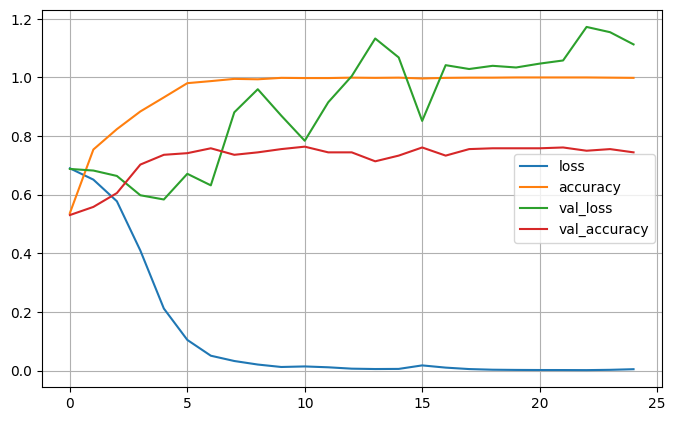

In [438]:
plot2(history6)

In [439]:
model6.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 1.4334 - accuracy: 0.6850


[1.4334073066711426, 0.6850000023841858]

### Model 7

- Adding AttentionLayer
    - Use the hidden state h of the last time step and the cell state c of the last time step
    - Check their attention
    - And use [attention out + hidden state h of the last time step] for decision

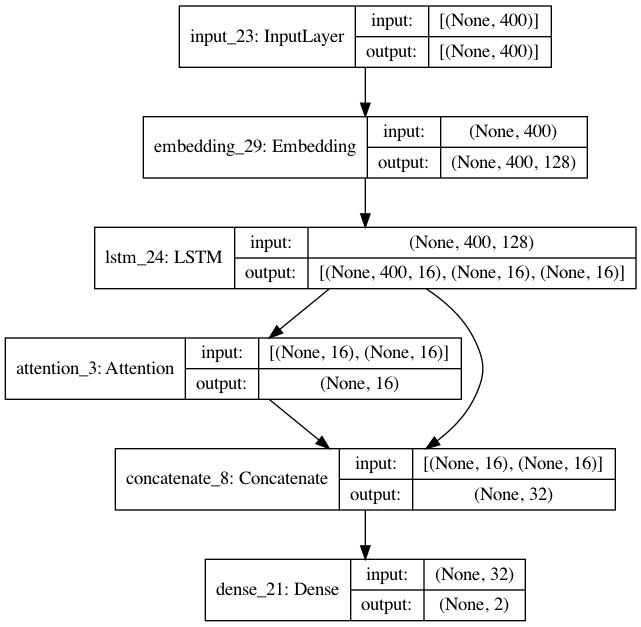

In [442]:
EMBEDDING_DIM = 128

inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len)(inputs)
#x=layers.SpatialDropout1D(0.2)(x)
x_all_hs, x_last_h, x_last_c = layers.LSTM(16, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=True, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden state of the last time step
#     (2) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (3) the cell state of the last time step


atten_out = layers.Attention()([x_last_h, x_last_c])

x = layers.Concatenate(axis=1)([x_last_h, atten_out])
outputs=layers.Dense(2, activation='softmax')(x)
model7 = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

plot_model(model7, show_shapes=True)

In [443]:
model7.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history7 = model7.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 7s - loss: 0.6922 - accuracy: 0.5160 - val_loss: 0.6958 - val_accuracy: 0.4361
Epoch 2/25
12/12 - 4s - loss: 0.6801 - accuracy: 0.6556 - val_loss: 0.6881 - val_accuracy: 0.5667
Epoch 3/25
12/12 - 4s - loss: 0.6549 - accuracy: 0.7931 - val_loss: 0.6818 - val_accuracy: 0.5500
Epoch 4/25
12/12 - 4s - loss: 0.5860 - accuracy: 0.8479 - val_loss: 0.6383 - val_accuracy: 0.6444
Epoch 5/25
12/12 - 4s - loss: 0.3949 - accuracy: 0.8687 - val_loss: 0.5795 - val_accuracy: 0.7194
Epoch 6/25
12/12 - 4s - loss: 0.2062 - accuracy: 0.9319 - val_loss: 0.5756 - val_accuracy: 0.7333
Epoch 7/25
12/12 - 4s - loss: 0.1050 - accuracy: 0.9764 - val_loss: 0.6532 - val_accuracy: 0.7361
Epoch 8/25
12/12 - 4s - loss: 0.0507 - accuracy: 0.9868 - val_loss: 0.6896 - val_accuracy: 0.7417
Epoch 9/25
12/12 - 4s - loss: 0.0421 - accuracy: 0.9910 - val_loss: 0.9433 - val_accuracy: 0.7028
Epoch 10/25
12/12 - 4s - loss: 0.0246 - accuracy: 0.9965 - val_loss: 0.8450 - val_accuracy: 0.7611
Epoch 11/25
12/12 -

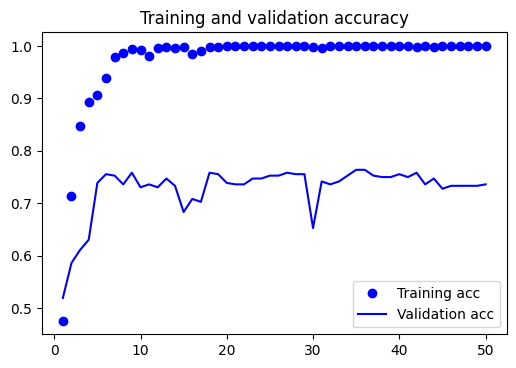

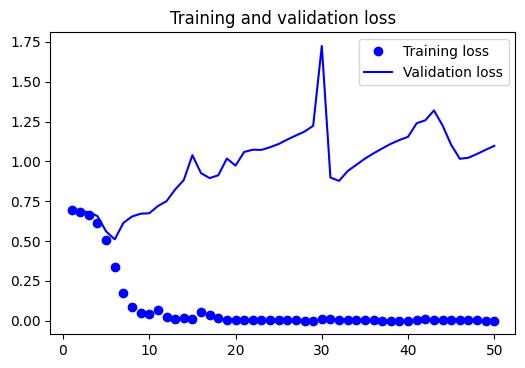

In [229]:
plot(history6)

## Explanation

In [230]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['negative','positive'], char_level=False)

In [231]:
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    #return np.array([[float(1-x), float(x)] for x in model.predict(np.array(_seq_pad))])
    return model2.predict(np.array(_seq_pad))



# np.array(sequence.pad_sequences(
#     tokenizer.texts_to_sequences([n for (n,l) in test_set]),
#     maxlen = max_len)).astype('float32')

In [232]:
reversed_word_index = dict([(index, word) for (word, index) in tokenizer.word_index.items()])

In [233]:
text_id =150

In [234]:
X_test[text_id]

array([1598,   22,   21,    1, 2099,    8, 8390,    3, 5483,   37, 1791,
          5,   78,   17,  113,    5, 6283,   17,  424,   33,  115, 3495,
       7598,    1, 1495,  275,   60,    1,   46,  714,   48,    1,  227,
          7,    5,    2, 6284, 1300,  124, 5483,  239,  346,   39,   17,
       3306,    3, 1618,   30,   61,    5, 6283,   17,  424,   20,    5,
        382,   59,   33,  112,   10,    7,   32,   15,    8,   89,    7,
        465,  175, 3131,    5, 9766,  143,  740,    1, 4715,   37, 5184,
         14,    1,  118,    8,    1, 6284, 1300,  602,    1,  298,    1,
       1482,    1, 2443,    4,    2, 3231,    6,    9, 1018,  341,  119,
       2736, 4570,  123,   30,  319,    1,  375,   34,  463,  102,    3,
         66,  123,   30, 1143,    5,    1,  293, 7419,   20,    5,  142,
       7419,  101,   36,  123,  383,   12, 2302, 4121,  877,  997, 1100,
       4716,    7,   30,   43,    5,  413,    1,   69,    4,    1, 4715,
         17,   69,    7,   44,  227,    3,    1, 57

In [235]:
X_test_texts[text_id]

"roberto benigni is a clown in the tradition of chaplin and keaton . this italian film star , best known in the united states for the poorly received son of the pink panther , has done the near impossible by creating a comic fable about the holocaust . but benigni ' s life is beautiful ( la vita e bella ) is not so much a story of the holocaust as it uses that monstrous outrage against humanity as a backdrop to tell a story of familial love , devotion and sacrifice . the movie starts out as a typical slapstick farce with benigni ' s guido arriving in the small tuscan town of arezzo in 1938 to fulfill his dream of owning a bookstore . like many of the slapstick clowns who preceded him , most notably the almost - forgotten harry langdon , benigni ' s guido has a childlike innocence . he ignores the growing anti - semitism of the fascist government . instead , guido ardently falls in love and persues dora , a local school teacher who already is engaged to a local fascist official . in ben

In [236]:
' '.join([reversed_word_index.get(i, '?') for i in X_test[text_id]])

"anti are on the rise in italy and guido has determined to do his best to shield his son from these harsh realities the task becomes even the more difficult when the family is to a concentration camp here guido must use all his skill and imagination not only to shield his son but to keep him from being it is at this in life is beautiful may tend to offend those whom the holocaust has touched for the scenes in the concentration camp lack the horror the pain the suffering of a schindler ' s list true many italian jews were not until the war was nearly over and most were not sent to the death camps but to work camps where they were used as slave labor unlike steven spielberg benigni is not out to tell the story of the holocaust his story is about family and the lengths a parent will go to protect a child for guido to save his son transforms the entire experience into an elaborate game must follow the rules without question to 1 000 points the winner takes home a tank therefore guido tells

In [237]:
print(X_test[22])
print(X_test_texts[22])

[ 158   10  462  498    5 1432    1  553  150    3 4947    1 3552   14
   52 2282 7849    5   88    2  195  134  507  282    1   86   31   54
  680    2  219    4  508   12   79   31  175  198  135    5   41    8
 1266    5 5278    6   56    2   31   22    2    6 1194   50  821   31
   22    2 3635  971    4    1 7771    4  834 7755 1549   19 1861  834
 7755  344   13  858 3019   11    7   56   67 1406    3 9146 5278    6
    7  185   20    2 3475 1565 1267    4    1   83  274  408    7    1
 1862 1880    4 5809 2856    1  482 3401  709 1525   45 5911  573   13
    1   79 3970 2508  127  120 4029 2426    2 6635   14 6886    1 6503
    3 2384    4 2277    8 6927 3073    6    3   48    8    1 3070   18
   90 1683  142   20    1  468    7   93 3551  260    1 1829 2483 2281
    4 4568 2508  384   58    2 1924  686  134 2324 2374    4 4002 6580
    6    9 2354 1253   55  177  157  312   13   26   73    6    9 9935
  220    2 1233 1626   15    7   30  135   31  270    2  174    5   25
 2221 

In [238]:
X_test_texts[text_id]

"roberto benigni is a clown in the tradition of chaplin and keaton . this italian film star , best known in the united states for the poorly received son of the pink panther , has done the near impossible by creating a comic fable about the holocaust . but benigni ' s life is beautiful ( la vita e bella ) is not so much a story of the holocaust as it uses that monstrous outrage against humanity as a backdrop to tell a story of familial love , devotion and sacrifice . the movie starts out as a typical slapstick farce with benigni ' s guido arriving in the small tuscan town of arezzo in 1938 to fulfill his dream of owning a bookstore . like many of the slapstick clowns who preceded him , most notably the almost - forgotten harry langdon , benigni ' s guido has a childlike innocence . he ignores the growing anti - semitism of the fascist government . instead , guido ardently falls in love and persues dora , a local school teacher who already is engaged to a local fascist official . in ben

In [239]:
model_predict_pipeline([X_test_texts[text_id]])

array([[0.00004177, 0.9999583 ]], dtype=float32)

In [240]:
text_id=3
exp = explainer.explain_instance(
X_test_texts[text_id], model_predict_pipeline, num_features=20, top_labels=1)
exp.show_in_notebook(text=True)

In [241]:
exp.show_in_notebook(text=True)

In [242]:
y_test[text_id]

1